<a href="https://colab.research.google.com/github/Enovak001/DigitRecognizer/blob/main/digit_recognizer_improvement_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip '/content/drive/MyDrive/DigitRecognizer/digit-recognizer.zip' -d '/content/drive/MyDrive/DigitRecognizer'

**Data Description**

* The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

* The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

* Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

* For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

* Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```

000 001 002 003 ... 026 027

028 029 030 031 ... 054 055

056 057 058 059 ... 082 083

 |   |   |   |  ...  |   |
 
728 729 730 731 ... 754 755

756 757 758 759 ... 782 783

```

* The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

* Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:
```
ImageId,Label
1,3
2,7
3,8 
(27997 more lines)
```
*The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [ ]:
import tensorflow as tf
print('TF version:', tf.__version__)

import tensorflow_hub as hub
print('TF Hub version:', hub.__version__)

from tensorflow.python.framework.config import list_physical_devices
# Check for GPU availability
print('GPU', 'available!' if tf.config.list_physical_devices('GPU') else 'not available.')

import pandas as pd
import matplotlib.pyplot as plt
import math

# To be able to view an image
from IPython.display import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

print('PyTorch version:', torch.__version__)


TF version: 2.8.2
TF Hub version: 0.12.0
GPU available!
PyTorch version: 1.12.1+cu113


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DigitRecognizer/train.csv')
print(data.describe())
print(data.head())

              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0

#### Considering Kaggle instructions are as follows, we need to create test set of 28000 elements:

* Your submission file should be in the following format: **For each of the 28000 images in the test set**, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

* ImageId,Label 1,3 2,7 3,8 (27997 more lines)

* The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [ ]:
len(data)

42000

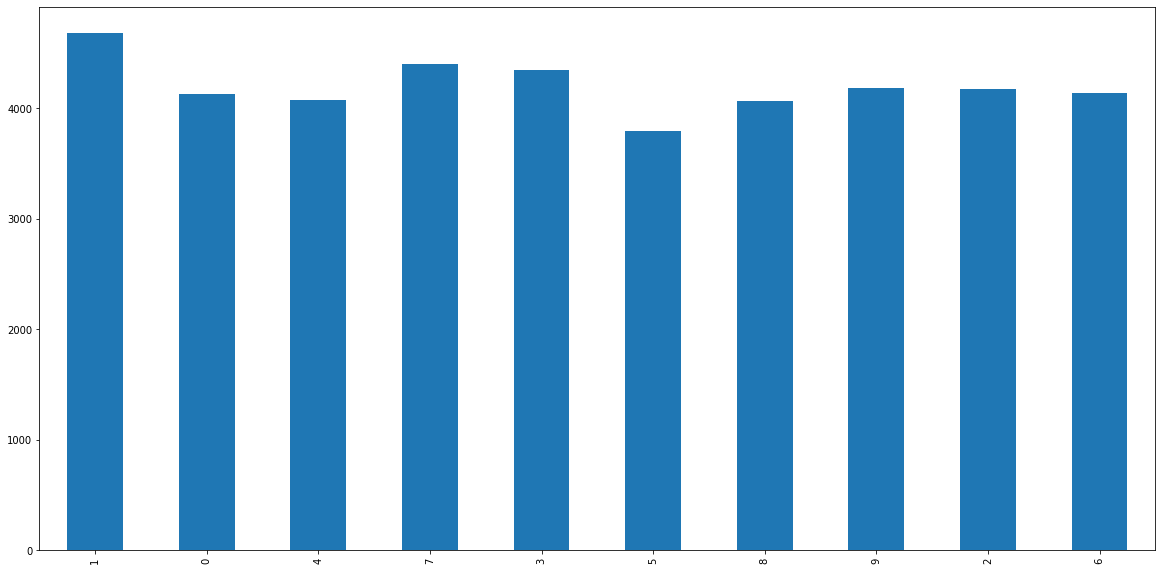

In [ ]:
# How many images are there of each digit?
import matplotlib.pyplot as plt

data['label'].value_counts(sort=False, ascending=True).plot.bar(figsize=(20,10))

In [ ]:
temp_train_data = data[:len(data)-6000]

In [ ]:
len(temp_train_data)

36000

In [ ]:
temp_test_data = data[len(data)-6000:]

In [ ]:
len(temp_test_data)

6000

In [ ]:
len(temp_train_data) + len(temp_test_data)

42000

#### Now we have train and test sets

In [ ]:
train_labels = temp_train_data['label'].to_numpy()

In [ ]:
test_labels = temp_test_data['label'].to_numpy()

In [ ]:
train_labels[:10]

array([1, 0, 1, 4, 0, 0, 7, 3, 5, 3])

In [ ]:
class_names_temp = data['label'].unique()
class_names = np.sort(class_names_temp)
class_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
train_image = temp_train_data.drop('label', axis=1).to_numpy()
train_image[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
test_image = temp_test_data.drop('label', axis=1).to_numpy()
test_image[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
len(train_image)

36000

In [ ]:
len(train_image[0])

784

In [ ]:
len(test_image)

6000

In [ ]:
train_image.dtype

dtype('int64')

## Creating Train Data

In [ ]:
train_data = []
for label in range(len(train_image)):
  train_data.append([tf.constant(train_labels[label]), tf.constant(train_image[label])])

In [ ]:
train_data[:3]

[[<tf.Tensor: shape=(), dtype=int64, numpy=1>,
  <tf.Tensor: shape=(784,), dtype=int64, numpy=
  array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0

In [ ]:
test_data = []
for label in range(len(test_image)):
  test_data.append([tf.constant(test_labels[label]), tf.constant(test_image[label])])

In [ ]:
test_data[0]

[<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(784,), dtype=int64, numpy=
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,
        255, 255, 255,   0,   0

In [ ]:
# create a function for converting a tabular img presentation into array, and later into Tensor
def turn_tabular_into_array(array):
  img_array = []

  for i in range(len(array)):
    new_array = np.array(array[i]).reshape(28,28)
  
    img_array.append(new_array)
  return img_array   

In [ ]:
len(train_image)

36000

In [ ]:
train_image = turn_tabular_into_array(train_image)

In [ ]:
test_image = turn_tabular_into_array(test_image)

In [ ]:
len(train_image)

36000

In [ ]:
train_image[0].dtype

dtype('int64')

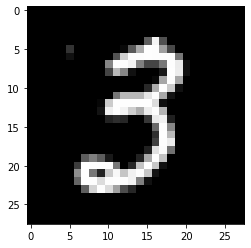

In [ ]:
plt.imshow(train_image[3658], cmap='gray')

In [ ]:
# plot 16 random images
import random

def show_16_images(images, labels):
  '''
  Displays a plot of 16 images and their lables from data batch
  '''
  # Setup the figure
  plt.figure(figsize=(10 , 10))

  # Loop through images
  for i in range(16):
    im = random.randint(0, (len(labels)-1))
    # Create subplots (4 rows, 4 cols)
    ax = plt.subplot(4, 4, i+1)
    # Display a image
    plt.imshow(images[im], cmap='gray')
    # Add image label as the title
    plt.title(labels[im])
    # Turn the gridlines 'off'
    plt.axis('off')


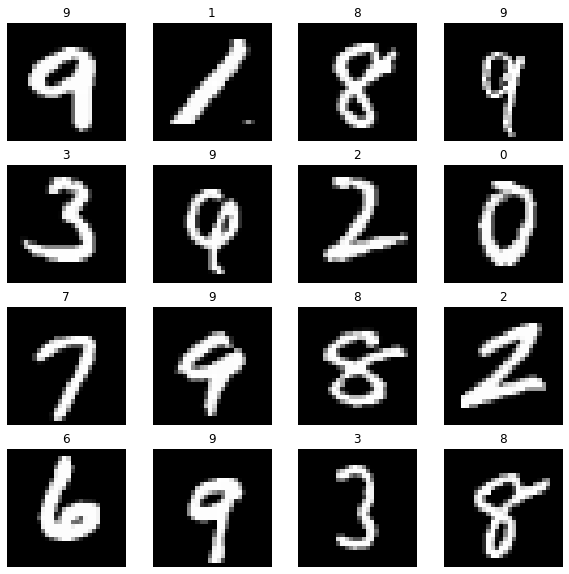

In [ ]:
show_16_images(train_image, train_labels)

In [ ]:
import torch

train_img_tensor = torch.from_numpy(train_image[0])

In [ ]:
train_img_tensor

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0, 188, 255,  94,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Turn image into Tensor

In [ ]:
# Make a function to turn data into Tensors
def turn_to_tensors(image):
  img_tensor = []

  for i in range(len(image)):
    img_tensor.append(torch.from_numpy(image[i]).type(torch.float32).unsqueeze(dim=0)/255)
  return img_tensor

In [ ]:
train_tensor_img = turn_to_tensors(train_image)

In [ ]:
test_tensor_img = turn_to_tensors(test_image)

In [ ]:
train_tensor_img[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
train_tensor_img[0].shape, train_tensor_img[0].dtype

(torch.Size([1, 28, 28]), torch.float32)

In [ ]:
def create_data(image, label):
  
  return image, label

In [ ]:
for i in range(len(train_labels)):
  train_data[i] = create_data(train_tensor_img[i], train_labels[i])

In [ ]:
for i in range(len(test_labels)):
  test_data[i] = create_data(test_tensor_img[i], test_labels[i])

In [ ]:
type(train_data), type(test_data), type(train_data[0]), type(test_data[0])

(list, list, tuple, tuple)

In [ ]:
#train_data_arr = np.array(train_data)

In [ ]:
#train_data_arr

In [ ]:
len(train_data[0]), len(train_data)

(2, 36000)

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcdda944e10>, <torch.utils.data.dataloader.DataLoader object at 0x7fcdda9442d0>)
Length of train dataloader: 1125 batches of 32
Length of test dataloader: 188 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_labels_batch, train_features_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32]), torch.Size([32, 1, 28, 28]))

In [ ]:
# Create a convolutional neural network 
class DigitRecognitionV0(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )
        # self.block_3 = nn.Sequential(
        #     nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(f'block_1 size: {x.shape}')
        x = self.block_2(x)
        #print(f'block_2 size: {x.shape}')
        # x = self.block_3(x)
        #print(f'block_3 size: {x.shape}')
        x = self.classifier(x)
        #print(f'classifier size: {x.shape}')
        return x

torch.manual_seed(42)
model_0 = DigitRecognitionV0(input_shape=1, 
    hidden_units=15, 
    output_shape=len(class_names)).to(device)
model_0

DigitRecognitionV0(
  (block_1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=735, out_features=10, bias=True)
  )
)

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
#list(enumerate(train_dataloader))[:2]

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 6

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        X, y = X.to(device), y.to(device)
        #print(X[0])
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).to(device))
                                           )

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.02955 | Test loss: 0.05443, Test acc: 98.24%

Epoch: 1
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.02556 | Test loss: 0.05254, Test acc: 98.35%

Epoch: 2
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.02329 | Test loss: 0.05341, Test acc: 98.30%

Epoch: 3
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.02060 | Test loss: 0.05063, Test acc: 98.52%

Epoch: 4
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.01875 | Test loss: 0.04952, Test acc: 98.42%

Epoch: 5
-------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples

Train loss: 0.01611 | Test loss: 0.05181, Test acc: 98.47%

Train time on Pa

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'DigitRecognitionV0',
 'model_loss': 0.053979888558387756,
 'model_acc': 98.40425531914893}

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        print(f'{data_loader} length = {len(data_loader)}')

In [ ]:
torch.manual_seed(42)

model_1 = DigitRecognitionV0(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_1

DigitRecognitionV0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_1.parameters(), 
#                             lr=0.001)
#### Epoch: 5
#### ---------
#### Train loss: 0.05769 | Train accuracy: 98.18%
#### Test loss: 0.07674 | Test accuracy: 97.61%

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_1.parameters(), 
#                             lr=0.01)
#### Epoch: 5
#### ---------
#### Train loss: 0.07600 | Train accuracy: 97.63%
#### Test loss: 0.11902 | Test accuracy: 96.52%


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 6
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples
Train loss: 0.42450 | Train accuracy: 86.03%
Test loss: 0.10339 | Test accuracy: 96.69%

<torch.utils.data.dataloader.DataLoader object at 0x7f5adb376310> length = 188
Epoch: 1
---------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples
Train loss: 0.09135 | Train accuracy: 97.13%
Test loss: 0.08291 | Test accuracy: 97.41%

<torch.utils.data.dataloader.DataLoader object at 0x7f5adb376310> length = 188
Epoch: 2
---------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples
Train loss: 0.07139 | Train accuracy: 97.78%
Test loss: 0.08955 | Test accuracy: 97.14%

<torch.utils.data.dataloader.DataLoader object at 0x7f5adb376310> length = 188
Epoch: 3
---------
Looked at 0/36000 samples
Looked at 12800/36000 samples
Looked at 25600/36000 samples
Train loss: 0.05807 | Train accuracy: 98.21%
Test loss: 0.07377 | Test accur

## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)
rand_test_samples = [] 
rand_test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  rand_test_samples.append(sample)
  rand_test_labels.append(label)

# View the first sample shape
rand_test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '0')

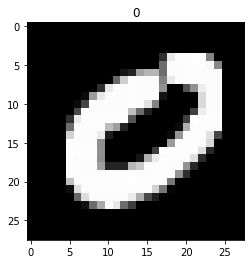

In [ ]:
plt.imshow(rand_test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[rand_test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_0,
                              data=rand_test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[9.9995e-01, 9.6893e-11, 1.0829e-05, 4.4710e-11, 2.4834e-09, 4.4232e-11,
         3.6096e-05, 9.0809e-11, 3.5447e-07, 8.9007e-07],
        [1.2538e-05, 1.6141e-07, 2.6815e-06, 3.2274e-07, 6.2938e-05, 6.7514e-07,
         9.9992e-01, 1.2110e-08, 2.2880e-06, 2.7277e-07]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 6, 8, 7, 3, 9, 4, 7, 9])

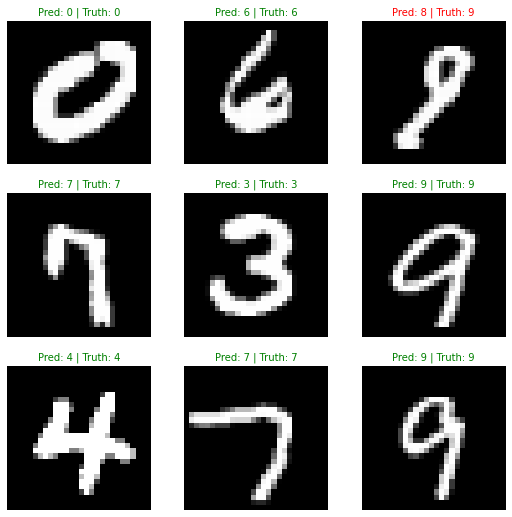

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(rand_test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form) 
  truth_label = class_names[rand_test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") 
  
  plt.axis(False);

## 10. Making a confusion matrix for further prediction evaluation 

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm 


# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/188 [00:00<?, ?it/s]

tensor([1, 5, 9,  ..., 7, 6, 9])

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend 
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 9.0 MB/s 
     |████████████████████████████████| 1.3 MB 45.6 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version: 0.20.0


In [ ]:
test_labels

array([1, 5, 9, ..., 7, 6, 9])

In [ ]:
len(test_labels)

6000

In [ ]:
tot_y_preds = []

for sublist in y_preds:
  for item in sublist:
    tot_y_preds.append(item.tolist())

```
flat_list = []
for sublist in l:
    for item in sublist:
        flat_list.append(item)
```

In [ ]:
len(y_preds)

188

In [ ]:
len(tot_y_preds)

6000

In [ ]:
tot_y_preds[0]

1

In [ ]:
check_test_labels = test_labels.tolist()

In [ ]:
len(check_test_labels)

6000

In [ ]:
y_preds[0]

tensor([1, 5, 9, 0, 1, 0, 0, 8, 3, 6, 4, 4, 7, 3, 2, 2, 0, 8, 9, 4, 2, 4, 7, 2,
        7, 2, 1, 1, 9, 0, 8, 9])

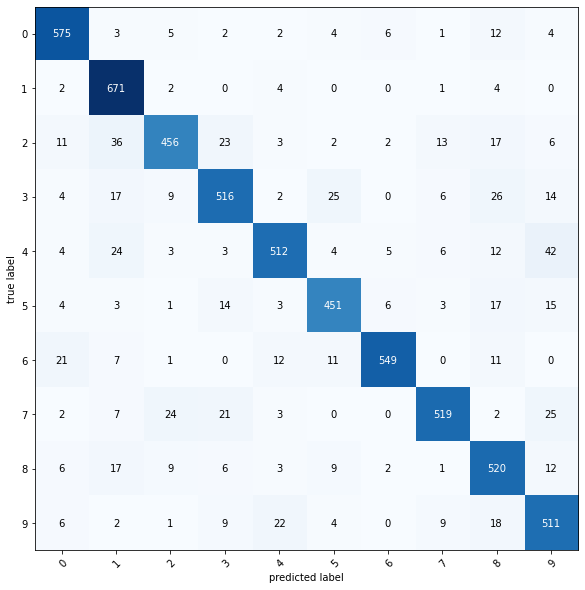

In [ ]:
# Ploting Confusion Matrix using PyTorch (torchmetrics) and Matplotlib
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=torch.tensor(tot_y_preds),
                         target=torch.tensor(check_test_labels))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(15, 10)
)

In [ ]:
# Ploting Confusion Matrix using SciKit Learn, Seaborn, Pandas and Matplotlib
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(check_test_labels, tot_y_preds, labels=class_names)
cm

array([[575,   3,   5,   2,   2,   4,   6,   1,  12,   4],
       [  2, 671,   2,   0,   4,   0,   0,   1,   4,   0],
       [ 11,  36, 456,  23,   3,   2,   2,  13,  17,   6],
       [  4,  17,   9, 516,   2,  25,   0,   6,  26,  14],
       [  4,  24,   3,   3, 512,   4,   5,   6,  12,  42],
       [  4,   3,   1,  14,   3, 451,   6,   3,  17,  15],
       [ 21,   7,   1,   0,  12,  11, 549,   0,  11,   0],
       [  2,   7,  24,  21,   3,   0,   0, 519,   2,  25],
       [  6,  17,   9,   6,   3,   9,   2,   1, 520,  12],
       [  6,   2,   1,   9,  22,   4,   0,   9,  18, 511]])

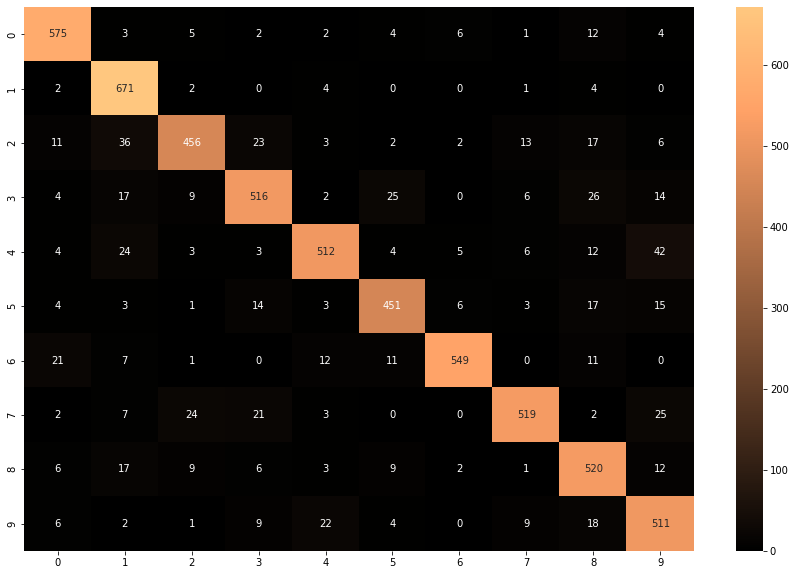

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = class_names,
                  columns = class_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, cmap='copper', annot=True, fmt='d');

## 11. Save and load best performing model

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "my_pytorch_computer_vision_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/my_pytorch_computer_vision_model_1.pth


In [ ]:
# Create a new instance
torch.manual_seed(42)

loaded_model_1 = DigitRecognitionV0(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_1.to(device)

DigitRecognitionV0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_1_results = eval_model(
    model=loaded_model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_1_results

{'model_name': 'DigitRecognitionV0',
 'model_loss': 0.06526660174131393,
 'model_acc': 98.10505319148936}

In [ ]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_1_results

{'model_name': 'DigitRecognitionV0',
 'model_loss': 0.06526660174131393,
 'model_acc': 98.10505319148936}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_1_results["model_loss"]),
              torch.tensor(loaded_model_1_results["model_loss"]),
              atol=1e-02)

tensor(True)

In [ ]:
final_df = pd.DataFrame(index=None)
final_df

""


In [ ]:
submission_data = pd.read_csv('/content/drive/MyDrive/DigitRecognizer/test.csv')
print(submission_data.describe())
print(submission_data.head())

        pixel0   pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7  \
count  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel8   pixel9  ...      pixel774      pixel775      pixel776  \
count  28000.0  28000.0  ...  28000.000000  28000.000000  28000.000000   
mean       0.0      0.0  ...      0.164607      0.073214      0.028036   
std        0.0      0.0  ...      5.473293      

In [ ]:
submission_images = submission_data.to_numpy()

In [ ]:
submission_images

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
submission_images = turn_tabular_into_array(submission_images)

In [ ]:
submission_images = turn_to_tensors(submission_images)

In [ ]:
submission_images[0].max(), submission_images[0].shape, train_image[0].shape, train_tensor_img[0].shape

(tensor(1.), torch.Size([1, 28, 28]), (28, 28), torch.Size([1, 28, 28]))

In [ ]:
type(submission_images), type(train_image)

(list, list)

In [ ]:
# Make predictions
submission_pred_probs = make_predictions(model=loaded_model_1,
                              data=submission_images)

# View first two prediction probabilities
submission_pred_probs[:2]

tensor([[4.6403e-09, 2.8107e-12, 1.0000e+00, 5.1510e-11, 9.7642e-13, 2.0928e-14,
         4.4356e-16, 2.7682e-10, 1.5489e-09, 1.7285e-12],
        [9.9999e-01, 2.0926e-10, 1.3923e-07, 3.1078e-10, 2.7330e-11, 9.0789e-07,
         8.7525e-06, 3.9399e-10, 2.0822e-07, 9.4230e-07]])

In [ ]:
# Convert prediction probabilities to labels
submission_pred_classes = submission_pred_probs.argmax(dim=1)
submission_pred_classes

tensor([2, 0, 9,  ..., 3, 9, 2])

ValueError: ignored

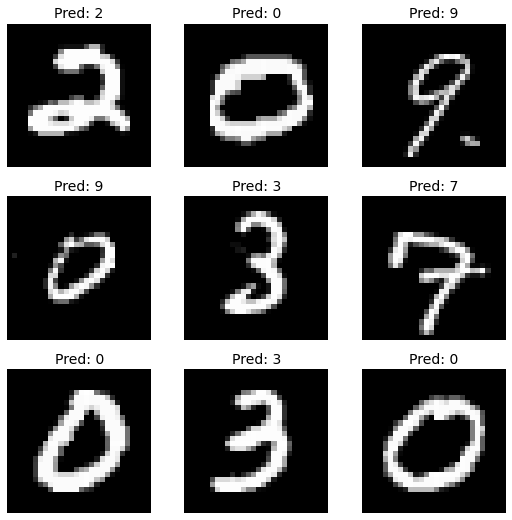

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(submission_images):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "6")
  pred_label = class_names[submission_pred_classes[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label}"
  plt.title(title_text, fontsize=14)
    
  plt.axis(False);

In [ ]:
submission_pred_list = submission_pred_classes.tolist()

In [ ]:
final_df['ImageId'] = range(1,len(submission_pred_classes)+1)

In [ ]:
final_df['Label'] = list(submission_pred_list)

In [ ]:
final_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
from pathlib import Path  
filepath = Path('/content/drive/MyDrive/DigitRecognizer/submission.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  

In [ ]:
final_df.to_csv(filepath, index=False)

In [ ]:
# import os  
# os.makedirs('folder/subfolder', exist_ok=True)  
# df.to_csv('folder/subfolder/out.csv')  